In [ ]:
pip install pandas numpy speechrecognition pydub googletrans==4.0.0-rc1 sentence-transformers matplotlib seaborn scikit-learn


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 222.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.3 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=4c2c4593ad86f8f02bade0cc749f98c75084ab092bcbee863ab01a3859fc67cf
  Stored in directory: /root/.cache/pip/wheels/39/17/6f/66a045ea3d168826074691b4b787b8f324d3f646d755443fda
Successfully built googletrans
  Attempting uninstall: h11
  

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Explanation for Murder:
Murder is defined under IPC section 302. It is the unlawful killing of a human being with intent.

Related IPC Sections:
Section IPC_303: Description of IPC Section 303
According to section 303 of Indian penal code, Whoever, being under sentence of imprisonment for life, commits murder, shall be punished with death.


IPC 303 in Simple Words
Section 303 of the Indian Penal Code states that if a person, who is already serving a life imprisonment sentence, commits murder, they can be punished with the death penalty.
Section IPC_307: Description of IPC Section 307
According to section 307 of Indian penal code, Whoever does any act with such intention or knowledge, and under such circumstances that, if he by that act caused death, he would be guilty of murder, shall be punished with imprisonment of either description for a term which may extend to ten years, and shall also be liable to fine; and, if hurt is caused to any person by such act, the offender shall be lia

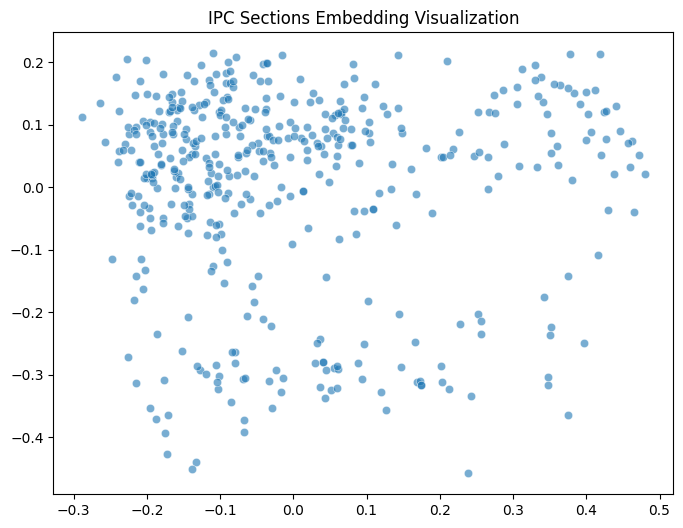

In [ ]:
import pandas as pd
import numpy as np
import speech_recognition as sr
from pydub import AudioSegment
from googletrans import Translator
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix

# Load IPC sections data
ipc_data_filepath = "ipc_sections.csv"  # Update with the correct file path
df = pd.read_csv(ipc_data_filepath)

# Telugu legal terms
legal_terms_te = ["హత్య", "దొంగతనం", "దాడి", "బలాత్కారం", "తప్పించుకుపోవడం", "మోసం", "లంచం", "అధికారం", "శిక్ష", "జరిమానా"]

# Initialize translator
translator = Translator()
legal_terms_en = [translator.translate(term, src='te', dest='en').text for term in legal_terms_te]

# Initialize the sentence transformer model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Combine IPC descriptions and compute embeddings
ipc_descriptions = df['Description'].fillna('') + " " + df['Offense'].fillna('')
ipc_embeddings = model.encode(ipc_descriptions.tolist(), convert_to_tensor=False)
legal_term_embeddings = model.encode(legal_terms_en, convert_to_tensor=False)

# Function to find related IPC sections
def find_related_ipc_sections(legal_term_embedding, ipc_embeddings, top_k=3):
    similarities = cosine_similarity([legal_term_embedding], ipc_embeddings)[0]
    sorted_indices = np.argsort(similarities)[::-1][:top_k]
    return [(df['Section'][i], df['Description'][i], similarities[i]) for i in sorted_indices]

# ASR setup
recognizer = sr.Recognizer()
def transcribe_audio(file_path, language='te-IN'):
    audio = AudioSegment.from_wav(file_path).set_channels(1)
    with sr.AudioFile(file_path) as source:
        audio_data = recognizer.record(source)
    try:
        return recognizer.recognize_google(audio_data, language=language)
    except sr.UnknownValueError:
        return ""
    except sr.RequestError as e:
        return ""

# Example audio file path
audio_file_path = "legal_sentences.wav"
transcription_te = transcribe_audio(audio_file_path, language='te-IN')

# Function to find legal terms in transcription
def find_legal_terms_in_transcription(transcription, legal_terms):
    return [term for term in legal_terms if term in transcription]

# Detect legal terms in transcription
found_terms_te = find_legal_terms_in_transcription(transcription_te, legal_terms_te)

# RAG Explanation Retrieval (Dummy Example Knowledge Base)
knowledge_base = {
    "Murder": "Murder is defined under IPC section 302. It is the unlawful killing of a human being with intent.",
    "Theft": "Theft is defined under IPC section 378. It involves dishonestly taking property belonging to another person.",
    "Assault": "Assault is covered under IPC section 351. It refers to an act that causes another person to apprehend violence.",
}

def generate_rag_explanation(legal_term, ipc_sections):
    term_explanation = knowledge_base.get(legal_term, "No explanation available in database.")
    ipc_text = "\n".join([f"Section {sec}: {desc}" for sec, desc, _ in ipc_sections])
    return f"Explanation for {legal_term}:\n{term_explanation}\n\nRelated IPC Sections:\n{ipc_text}"

# Generate explanations for found terms
for term_te, term_en, embedding in zip(legal_terms_te, legal_terms_en, legal_term_embeddings):
    if term_te in found_terms_te:
        related_sections = find_related_ipc_sections(embedding, ipc_embeddings, top_k=3)
        explanation = generate_rag_explanation(term_en, related_sections)
        print(explanation)

# Visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(ipc_embeddings)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], alpha=0.6)
plt.title("IPC Sections Embedding Visualization")
plt.show()

Explanation for Murder:
Definition: Murder is defined under IPC section 302.
Penalty: Punishable with life imprisonment or death penalty.
Example: If person A intentionally kills person B, it is murder.

Related IPC Sections:
Section IPC_303: Description of IPC Section 303
According to section 303 of Indian penal code, Whoever, being under sentence of imprisonment for life, commits murder, shall be punished with death.


IPC 303 in Simple Words
Section 303 of the Indian Penal Code states that if a person, who is already serving a life imprisonment sentence, commits murder, they can be punished with the death penalty.
Section IPC_307: Description of IPC Section 307
According to section 307 of Indian penal code, Whoever does any act with such intention or knowledge, and under such circumstances that, if he by that act caused death, he would be guilty of murder, shall be punished with imprisonment of either description for a term which may extend to ten years, and shall also be liable to 

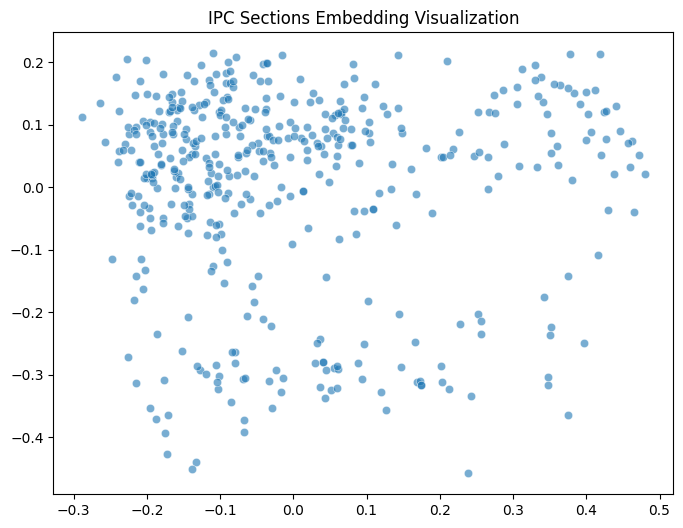

In [ ]:
import pandas as pd
import numpy as np
import speech_recognition as sr
from pydub import AudioSegment
from googletrans import Translator
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix

# Load IPC sections data
ipc_data_filepath = "ipc_sections.csv"  # Update with the correct file path
df = pd.read_csv(ipc_data_filepath)

# Telugu legal terms
legal_terms_te = ["హత్య", "దొంగతనం", "దాడి", "బలాత్కారం", "తప్పించుకుపోవడం", "మోసం", "లంచం", "అధికారం", "శిక్ష", "జరిమానా"]

# Initialize translator
translator = Translator()
legal_terms_en = [translator.translate(term, src='te', dest='en').text for term in legal_terms_te]

def translate_te_to_en(term_te):
    index = legal_terms_te.index(term_te) if term_te in legal_terms_te else None
    return legal_terms_en[index] if index is not None else term_te

# Initialize the sentence transformer model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Combine IPC descriptions and compute embeddings
ipc_descriptions = df['Description'].fillna('') + " " + df['Offense'].fillna('')
ipc_embeddings = model.encode(ipc_descriptions.tolist(), convert_to_tensor=False)
legal_term_embeddings = model.encode(legal_terms_en, convert_to_tensor=False)

# Function to find related IPC sections
def find_related_ipc_sections(legal_term_embedding, ipc_embeddings, top_k=3):
    similarities = cosine_similarity([legal_term_embedding], ipc_embeddings)[0]
    sorted_indices = np.argsort(similarities)[::-1][:top_k]
    return [(df['Section'][i], df['Description'][i], similarities[i]) for i in sorted_indices]

# ASR setup
recognizer = sr.Recognizer()
def transcribe_audio(file_path, language='te-IN'):
    audio = AudioSegment.from_wav(file_path).set_channels(1)
    with sr.AudioFile(file_path) as source:
        audio_data = recognizer.record(source)
    try:
        return recognizer.recognize_google(audio_data, language=language)
    except sr.UnknownValueError:
        return ""
    except sr.RequestError as e:
        return ""

# Example audio file path
audio_file_path = "legal_sentences.wav"
transcription_te = transcribe_audio(audio_file_path, language='te-IN')

# Function to find legal terms in transcription
def find_legal_terms_in_transcription(transcription, legal_terms):
    return [term for term in legal_terms if term in transcription]

# Detect legal terms in transcription
found_terms_te = find_legal_terms_in_transcription(transcription_te, legal_terms_te)
found_terms_en = [translate_te_to_en(term) for term in found_terms_te]

# Multi-Level RAG Explanation Retrieval
knowledge_base = {
    "Murder": {"definition": "Murder is defined under IPC section 302.",
                "penalty": "Punishable with life imprisonment or death penalty.",
                "example": "If person A intentionally kills person B, it is murder."},
    "Theft": {"definition": "Theft is defined under IPC section 378.",
               "penalty": "Punishable with imprisonment up to 3 years or fine.",
               "example": "If someone steals a mobile phone from a shop, it is theft."},
    "Bribery": {"definition": "Bribery is covered under IPC section 171B.",
                 "penalty": "Punishable with imprisonment up to 7 years.",
                 "example": "If an officer demands money to approve a file, it is bribery."},
}

def generate_multilevel_rag_explanation(legal_term, ipc_sections):
    term_data = knowledge_base.get(legal_term, {})
    definition = term_data.get("definition", "No definition available.")
    penalty = term_data.get("penalty", "No penalty details available.")
    example = term_data.get("example", "No example available.")

    ipc_text = "\n".join([f"Section {sec}: {desc}" for sec, desc, _ in ipc_sections])
    return f"Explanation for {legal_term}:\nDefinition: {definition}\nPenalty: {penalty}\nExample: {example}\n\nRelated IPC Sections:\n{ipc_text}"

# Generate multi-level explanations for found terms
for term_en in found_terms_en:
    index = legal_terms_en.index(term_en) if term_en in legal_terms_en else None
    embedding = legal_term_embeddings[index] if index is not None else None
    if embedding is not None:
        related_sections = find_related_ipc_sections(embedding, ipc_embeddings, top_k=3)
        explanation = generate_multilevel_rag_explanation(term_en, related_sections)
        print(explanation)

# Visualization with PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(ipc_embeddings)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], alpha=0.6)
plt.title("IPC Sections Embedding Visualization")
plt.show()


Explanation for Murder:
Definition: Murder is defined under IPC section 302.
Penalty: Punishable with life imprisonment or death penalty.
Example: If person A intentionally kills person B, it is murder.

Related IPC Sections:
Section IPC_303: Description of IPC Section 303
According to section 303 of Indian penal code, Whoever, being under sentence of imprisonment for life, commits murder, shall be punished with death.


IPC 303 in Simple Words
Section 303 of the Indian Penal Code states that if a person, who is already serving a life imprisonment sentence, commits murder, they can be punished with the death penalty.
Section IPC_307: Description of IPC Section 307
According to section 307 of Indian penal code, Whoever does any act with such intention or knowledge, and under such circumstances that, if he by that act caused death, he would be guilty of murder, shall be punished with imprisonment of either description for a term which may extend to ten years, and shall also be liable to 

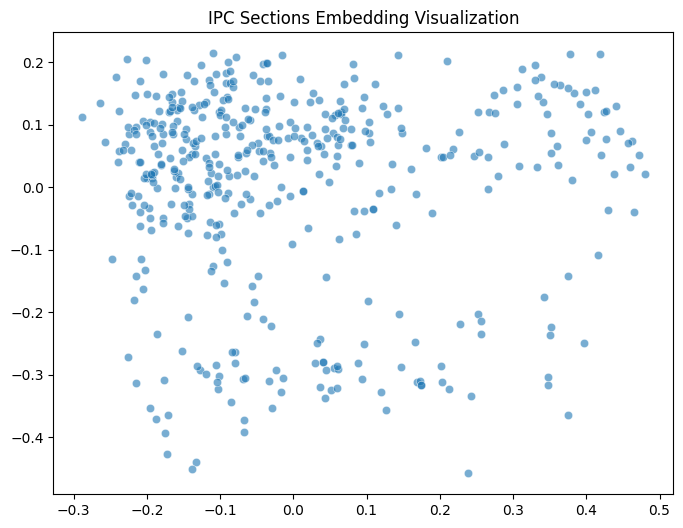

In [ ]:
import pandas as pd
import numpy as np
import speech_recognition as sr
from pydub import AudioSegment
from googletrans import Translator
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix

# Load IPC sections data
ipc_data_filepath = "ipc_sections.csv"  # Update with the correct file path
df = pd.read_csv(ipc_data_filepath)

# Telugu legal terms
legal_terms_te = ["హత్య", "దొంగతనం", "దాడి", "బలాత్కారం", "తప్పించుకుపోవడం", "మోసం", "లంచం", "అధికారం", "శిక్ష", "జరిమానా"]

# Initialize translator
translator = Translator()
legal_terms_en = [translator.translate(term, src='te', dest='en').text for term in legal_terms_te]

def translate_te_to_en(term_te):
    index = legal_terms_te.index(term_te) if term_te in legal_terms_te else None
    return legal_terms_en[index] if index is not None else term_te

# Initialize the sentence transformer model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Combine IPC descriptions and compute embeddings
ipc_descriptions = df['Description'].fillna('') + " " + df['Offense'].fillna('')
ipc_embeddings = model.encode(ipc_descriptions.tolist(), convert_to_tensor=False)
legal_term_embeddings = model.encode(legal_terms_en, convert_to_tensor=False)

# Function to find related IPC sections
def find_related_ipc_sections(legal_term_embedding, ipc_embeddings, top_k=3):
    similarities = cosine_similarity([legal_term_embedding], ipc_embeddings)[0]
    sorted_indices = np.argsort(similarities)[::-1][:top_k]
    return [(df['Section'][i], df['Description'][i], similarities[i]) for i in sorted_indices]

# ASR setup
recognizer = sr.Recognizer()
def transcribe_audio(file_path, language='te-IN'):
    audio = AudioSegment.from_wav(file_path).set_channels(1)
    with sr.AudioFile(file_path) as source:
        audio_data = recognizer.record(source)
    try:
        return recognizer.recognize_google(audio_data, language=language)
    except sr.UnknownValueError:
        return ""
    except sr.RequestError as e:
        return ""

# Example audio file path
audio_file_path = "legal_sentences.wav"
transcription_te = transcribe_audio(audio_file_path, language='te-IN')

# Function to find legal terms in transcription
def find_legal_terms_in_transcription(transcription, legal_terms):
    return [term for term in legal_terms if term in transcription]

# Detect legal terms in transcription
found_terms_te = find_legal_terms_in_transcription(transcription_te, legal_terms_te)
found_terms_en = [translate_te_to_en(term) for term in found_terms_te]

# Multi-Level RAG Explanation Retrieval
knowledge_base = {
    "Murder": {"definition": "Murder is defined under IPC section 302.",
                "penalty": "Punishable with life imprisonment or death penalty.",
                "example": "If person A intentionally kills person B, it is murder."},
    "Theft": {"definition": "Theft is defined under IPC section 378.",
               "penalty": "Punishable with imprisonment up to 3 years or fine.",
               "example": "If someone steals a mobile phone from a shop, it is theft."},
    "Bribery": {"definition": "Bribery is covered under IPC section 171B.",
                 "penalty": "Punishable with imprisonment up to 7 years.",
                 "example": "If an officer demands money to approve a file, it is bribery."},
    "Attack": {"definition": "An act of physical aggression causing harm or injury.",
                "penalty": "Punishable under IPC sections 319-326, with imprisonment and fines depending on severity.",
                "example": "If a person physically assaults another with an intent to harm, it is classified as an attack."},
    "Dacoity": {"definition": "Dacoity involves five or more persons committing robbery.",
                "penalty": "Punishable under IPC 395 with life imprisonment or rigorous imprisonment up to 10 years.",
                "example": "If five individuals break into a house and rob valuables, it is considered dacoity."}
}

def generate_multilevel_rag_explanation(legal_term, ipc_sections):
    term_data = knowledge_base.get(legal_term, {})
    definition = term_data.get("definition", "No definition available.")
    penalty = term_data.get("penalty", "No penalty details available.")
    example = term_data.get("example", "No example available.")

    ipc_text = "\n".join([f"Section {sec}: {desc}" for sec, desc, _ in ipc_sections])
    return f"Explanation for {legal_term}:\nDefinition: {definition}\nPenalty: {penalty}\nExample: {example}\n\nRelated IPC Sections:\n{ipc_text}"

# Generate multi-level explanations for found terms
for term_en in found_terms_en:
    index = legal_terms_en.index(term_en) if term_en in legal_terms_en else None
    embedding = legal_term_embeddings[index] if index is not None else None
    if embedding is not None:
        related_sections = find_related_ipc_sections(embedding, ipc_embeddings, top_k=3)
        explanation = generate_multilevel_rag_explanation(term_en, related_sections)
        print(explanation)

# Visualization with PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(ipc_embeddings)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], alpha=0.6)
plt.title("IPC Sections Embedding Visualization")
plt.show()